## Problem - 1 : Path Finding

Importing xlrd to read given excel file of capitals, Locationiq to get the staright line heuristic of the cities and graphviz to visualize the graph. The excel file specified should be in the same folder of this file.

In [1]:
import xlrd
from locationiq.geocoder import LocationIQ
from math import radians, sin, cos, acos
from graphviz import Graph

geocoder = LocationIQ('df1cea1ac0972a')

loc = (".\Indian_capitals.xlsx")

wb = xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)

The code below creates a dictianory with every city as a key and its value will be the neighbours of the key city with their path cost

In [2]:
cities = {}
for i in range(0, sheet.nrows):
    if sheet.cell_value(i, 0) not in cities:
        l = [sheet.cell_value(i, 1).strip(), sheet.cell_value(i, 2)]
        temp = []
        temp.append(l)
        cities[sheet.cell_value(i, 0).strip()] = temp
    else:
        l1 = cities[sheet.cell_value(i, 0)]
        temp = []
        temp.append(sheet.cell_value(i, 1).strip())
        temp.append(sheet.cell_value(i, 2))
        l1.append(temp)
for i in range(1, sheet.nrows):
    if sheet.cell_value(i, 1) not in cities:
        l = [sheet.cell_value(i, 0).strip(), sheet.cell_value(i, 2)]
        temp = []
        temp.append(l)
        cities[sheet.cell_value(i, 1).strip()] = temp
    else:
        l1 = cities[sheet.cell_value(i, 1)]
        temp = []
        temp.append(sheet.cell_value(i, 0).strip())
        temp.append(sheet.cell_value(i, 2))
        l1.append(temp)


Creates a graph node for every key in dict cities and forms an edge for each of its neighbours and prints the graph

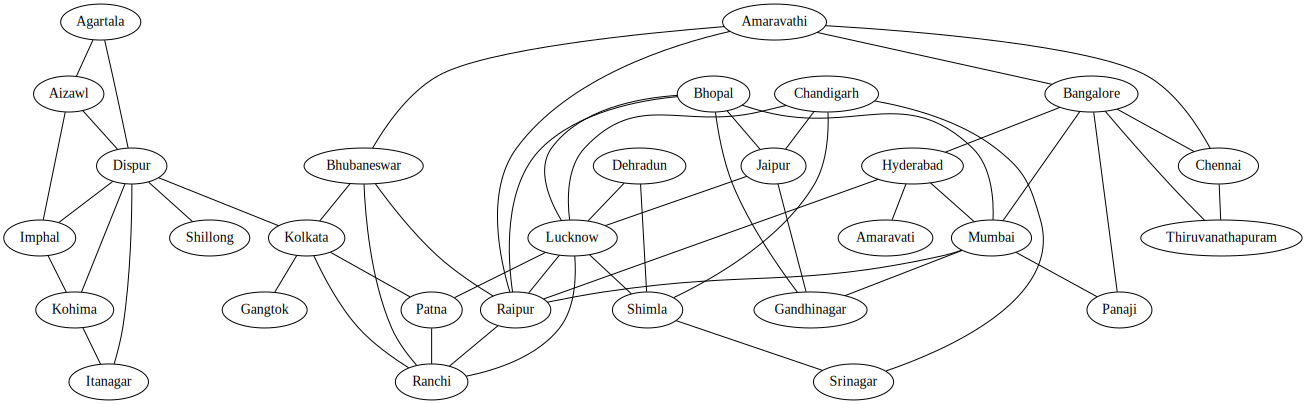

In [3]:
dot = Graph(strict=True)

for x in cities.keys():
    dot.node(x,x)
for x in cities.keys():
    for y in cities[x]:
        dot.edge(x,y[0])
dot

### Problem Class
This is the problem class for the path finding problem which has actions, result and step_cost as its methods. actions method returns the neighbours( actions is to go to those neighbours ) of a given state. The result method computes the result of a given action. and step_cost returns the cost for performing the action from the given state.

In [4]:
class Problem:
    def __init__(self, state, goal):
        self.state = state
        self.goal = goal

        self.initial_state = state

    def actions(self, state):
        l = cities[state]
        return l

    def result(self, state, action):
        return action

    def step_cost(self, state, action):
        l = cities[state]
        cost = 0
        for x in l:
            if x[0] == action:
                cost = x[1]
        return cost

### ChildNode Class
This class creates a object for a given problem object, action and parent. If the parent is none then it is initial node so the path cost will be zero, otherwise we compute the path cost from parent.step_cost method

In [5]:
class ChildNode:
    def __init__(self, problem, action, parent):
        if parent is None:
            self.state = problem.initial_state
            self.parent = None
            self.action = None
            self.path_cost = 0
        else:
            self.state = problem.result(parent.state, action)
            self.parent = parent
            self.action = 'to' + action
            self.path_cost = parent.path_cost + problem.step_cost(parent.state, action)


### Update_state
Updates the state for given percept and state.

In [6]:
def update_state(state, percept):
    state = percept[0]
    return state


### Formulate_Goal
Formulates the goal based on the percept. Currently it is the second item of the percept.

In [7]:
def formulate_goal(state, percept):
    return percept[1]

### Formulate_Problem
Creates a problem object for the given current state and goal.

In [8]:
def formulate_problem(state, goal):
    temp_problem = Problem(state, goal)
    return temp_problem

### Goal_Test
Checks weather a given state is goal or not. Note that goal is declared globally.

In [9]:
def goal_test(state):
    if state == goal:
        return True
    return False

### Solution
For a given node it back traverses to its parent until its parent is none and stores all its state in a list, which will be our action secquence.

In [10]:
def solution(node):
    path_list = []
    path_list.append(node.state)
    while node.parent is not None:
        node = node.parent
        path_list.append(node.state)
    path_list.reverse()
    return path_list

### Is Present In Set
For a given set and a node, it checks weather any element present which has same state attribute as node.

In [11]:
def is_present_in_set(temp_set, node):
    temp_list = list(temp_set)
    for x in temp_list:
        if x.state == node.state:
            return True
    return False

### BFS
Performs Breadth First Search for a given problem object and goal_test

In [12]:
def bfs(problem, goal_test):
    if goal_test(problem.state):
        print(problem.state)
        return
    frontier = []
    explored_set = set('')
    temp_orig = ChildNode(problem, None, None)
    frontier.append(temp_orig)
    while frontier is not None:
        node = frontier.pop(0)
        explored_set.add(node)
        for l in problem.actions(node.state):
            temp_child = ChildNode(problem, l[0], node)
            if not is_present_in_set(explored_set, temp_child) and not is_present_in_set(frontier, temp_child):
                # print(node.state, '->', temp_child.state)
                if goal_test(temp_child.state):
                    print('Path cost: ', temp_child.path_cost)
                    return solution(temp_child)
                frontier.append(temp_child)

### DFS
Performs Deapth First Search for a given problem object and goal_test

In [13]:
def dfs(problem, goal_test):
    if goal_test(problem.initial_state):
        print(problem.state)
        return
    frontier = []
    explored_set = set('')
    temp_orig = ChildNode(problem, None, None)
    frontier.append(temp_orig)
    while frontier is not None:
        node = frontier.pop()
        explored_set.add(node)
        for l in problem.actions(node.state):
            temp_child = ChildNode(problem, l[0], node)
            if not is_present_in_set(explored_set, temp_child) and not is_present_in_set(frontier, temp_child):
                # print(node.state, '->', temp_child.state)
                if goal_test(temp_child.state):
                    print('Path cost: ', temp_child.path_cost)
                    return solution(temp_child)
                frontier.append(temp_child)

For given two intersected nodes from either side it gives the sequence of steps that must be performed to reach the goal.

In [14]:
def bi_directional_solution(node, node1, explored_list):
    sol_list = []
    cost = node.path_cost
    sol_list.append(node.state)
    while node.parent is not None:
        for x in explored_list:
            if x == node.parent:
                sol_list.append(x.state)
                node = x
                break
    sol_list.reverse()
    cost += node1.path_cost
    while node1.parent is not None:
        for x in explored_list:
            if x == node1.parent:
                sol_list.append(x.state)
                node1 = x
                break
    print('path cost: ', cost)
    return sol_list

Finds weather there is any node in both the frontiers which has same state.

In [15]:
def find_common(frontier1, frontier2, explored_set):
    explored_list = list(explored_set)
    state = None
    for x in frontier1:
        for y in frontier2:
            if x.state == y.state:
                sol_list = bi_directional_solution(x, y, explored_list)
                return sol_list
    return state

### bi-Directional BFS
Performs bi directional Breadth First Search for a given problem object and goal_test

In [16]:
def bi_directional_bfs(problem, goal_test):
    if goal_test(problem.initial_state):
        print(problem.initial_state)
        return
    frontier_far = []
    frontier_bak = []
    explored_set = set('')
    temp_orig = ChildNode(problem, None, None)
    temp_dest = ChildNode(problem, None, None)
    temp_dest.state = problem.goal
    frontier_far.append(temp_orig)
    frontier_bak.append(temp_dest)
    while not find_common(frontier_far, frontier_bak, explored_set):
        node = frontier_far.pop(0)
        explored_set.add(node)
        for l in problem.actions(node.state):
            temp_child = ChildNode(problem, l[0], node)
            if not is_present_in_set(explored_set, temp_child) and not is_present_in_set(frontier_far, temp_child):
#                 print('Front: ', node.state, '->', temp_child.state)
                frontier_far.append(temp_child)

        node = frontier_bak.pop(0)
        explored_set.add(node)
        for l in problem.actions(node.state):
            temp_child = ChildNode(problem, l[0], node)
            if not is_present_in_set(explored_set, temp_child) and not is_present_in_set(frontier_bak, temp_child):
#                 print('Back: ', node.state, '->', temp_child.state)
                frontier_bak.append(temp_child)
    return find_common(frontier_far, frontier_bak, explored_set)

### Straight line Distance
Returns the straight line distance between source and destination using locationiq.

In [17]:
def straight_line_distance(source, destination):
    from time import sleep
    sleep(1.5)
    a = geocoder.geocode(source+",india")[0]
    b = geocoder.geocode(destination+",india")[0]
    slat = radians(float(a['lat']))
    slon = radians(float(a['lon']))
    elat = radians(float(b['lat']))
    elon = radians(float(b['lon']))
    dist = 6371.01 * acos(sin(slat) * sin(elat) + cos(slat) * cos(elat) * cos(slon - elon))
    # print('The distance is %.2fkm.' % dist)
    return dist

Returns the element from the frontier which has minimum heuristic function value. This also stores the straight line distances that are computed once in order to avoid repeated computations.



In [18]:
straight_list = []

def find_min(frontier, dest):
    node = frontier[0]
    if node.state not in straight_list:
        temp1 = straight_line_distance(node.state, dest)
        straight_list.append(node.state)
        straight_list.append(temp1)
        min_path = node.path_cost + temp1
    else:
        i = straight_list.index(node.state)
        min_path = node.path_cost + straight_list[i+1]
    for x in frontier:
        if x.state not in straight_list:
            temp1 = straight_line_distance(x.state, dest)
            straight_list.append(x.state)
            straight_list.append(temp1)
        else:
            i = straight_list.index(x.state)
            temp1 = straight_list[i+1]

        temp = x.path_cost + temp1
        if temp < min_path:
            min_path = temp
            node = x
    frontier.remove(node)
    return node


If a given node already exists in the frontier and it has minimum heuristic funcion, then it keeps the frontier intact. Otherwise it replaces it with the node which has min heuristic function.

In [19]:
def change_frontier(frontier, node):
    changed = False
    for i in range(0, len(frontier)):
        if node.state == frontier[i].state and frontier[i].path_cost > node.path_cost:
            frontier[i] = node
            changed = True
    return changed

### A*
Performs A* Search for a given problem object and goal_test

In [20]:
def astar(problem, goal_test):
    if goal_test(problem.initial_state):
        print(orig)
        return
    frontier = []
    explored_set = set('')
    temp_node = ChildNode(problem, None, None)
    frontier.append(temp_node)
    while frontier is not None:
        node = find_min(frontier, problem.goal)
        explored_set.add(node)
        l = cities[node.state]
        for l in problem.actions(node.state):
            temp_child = ChildNode(problem, l[0], node)
            if not is_present_in_set(explored_set, temp_child):
                changed = change_frontier(frontier, temp_child)
                # print(node.state, '->', temp_child.state)
                if goal_test(temp_child.state):
                    path_followed = solution(temp_child)
                    print('Path cost: ', temp_child.path_cost)
                    return path_followed
                if not changed:
                    frontier.append(temp_child)


### Simple Problem Solving Agent
This is the function of simple problem solving agent which takes in the percept, type of search algorithm, the goal test and returns the action secquence.

In [21]:
def Simple_Problem_Solving_Agent(percept, search, goal_test):
    seq = []
    state = percept[0]
    state = update_state(state, percept)
    global goal
    if seq == []:
        goal = formulate_goal(state, percept)
        problem = formulate_problem(state, goal)
        seq = search(problem, goal_test)
        # print('printing seq: ', seq)
        if seq == None:
            return None
        return seq

### Outputs for pre-defined inputs

### BFS output

Path cost:  3329.0
Path Followed ['Agartala', 'Dispur', 'Kolkata', 'Ranchi', 'Raipur', 'Hyderabad']



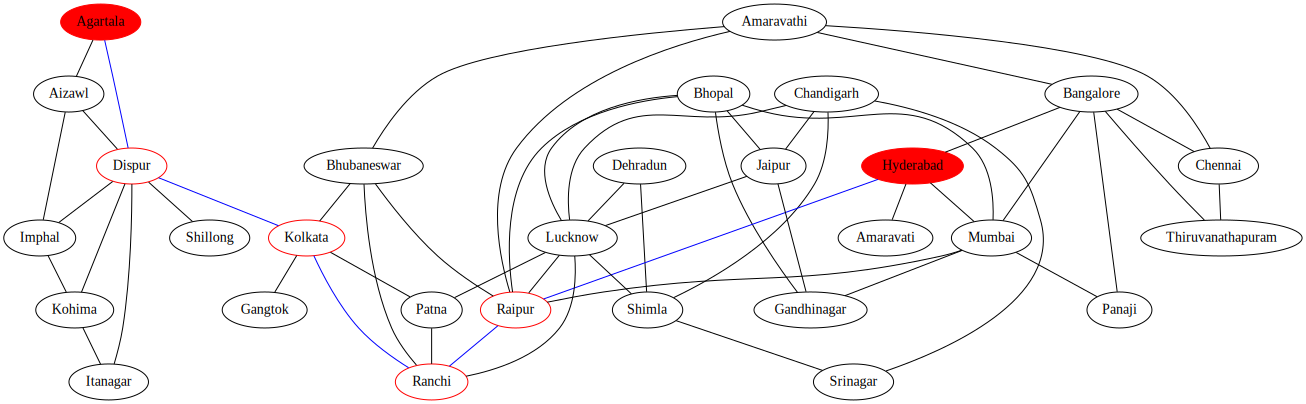

In [22]:
l = Simple_Problem_Solving_Agent(['Agartala', 'Hyderabad'],bfs, goal_test)
print('Path Followed', l)

dot.node(l[0], l[0], color = 'red', style = 'filled')
dot.node(l[len(l)-1], l[len(l)-1], color = 'red', style = 'filled')
for i in range(1, len(l)-1):
    dot.node(l[i], l[i], color = "red")
for i in range(0, len(l)-1):
    dot.edge(l[i], l[i+1], color = "blue")
print()
dot

### DFS output

Path cost:  4063.0
Path Followed ['Agartala', 'Dispur', 'Kolkata', 'Bhubaneswar', 'Amaravathi', 'Bangalore', 'Hyderabad']



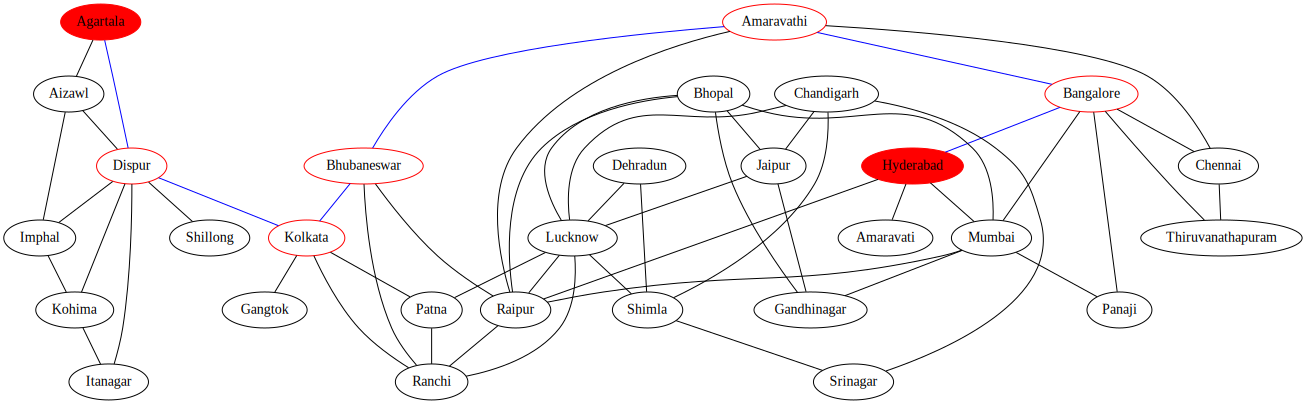

In [26]:
l = Simple_Problem_Solving_Agent(['Agartala', 'Hyderabad'],dfs, goal_test)
print('Path Followed', l)

dot = Graph(strict=True)

for x in cities.keys():
    dot.node(x,x)
for x in cities.keys():
    for y in cities[x]:
        dot.edge(x,y[0])
dot.node(l[0], l[0], color = 'red', style = 'filled')
dot.node(l[len(l)-1], l[len(l)-1], color = 'red', style = 'filled')
for i in range(1, len(l)-1):
    dot.node(l[i], l[i], color = "red")
for i in range(0, len(l)-1):
    dot.edge(l[i], l[i+1], color = "blue")
print()
dot

### bi_directional_bfs output

path cost:  3329.0
path cost:  3329.0
Path Followed ['Agartala', 'Dispur', 'Kolkata', 'Ranchi', 'Raipur', 'Hyderabad']



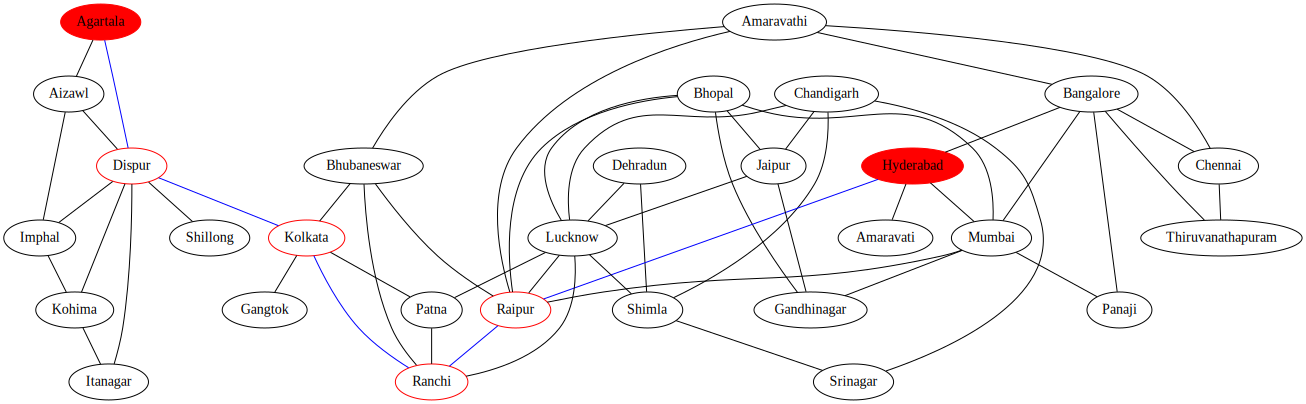

In [27]:
l = Simple_Problem_Solving_Agent(['Agartala', 'Hyderabad'],bi_directional_bfs, goal_test)
print('Path Followed', l)

dot = Graph(strict=True)

for x in cities.keys():
    dot.node(x,x)
for x in cities.keys():
    for y in cities[x]:
        dot.edge(x,y[0])

dot.node(l[0], l[0], color = 'red', style = 'filled')
dot.node(l[len(l)-1], l[len(l)-1], color = 'red', style = 'filled')
for i in range(1, len(l)-1):
    dot.node(l[i], l[i], color = "red")
for i in range(0, len(l)-1):
    dot.edge(l[i], l[i+1], color = "blue")
print()
dot

### A* output

Path cost:  3329.0
Path Followed ['Agartala', 'Dispur', 'Kolkata', 'Ranchi', 'Raipur', 'Hyderabad']



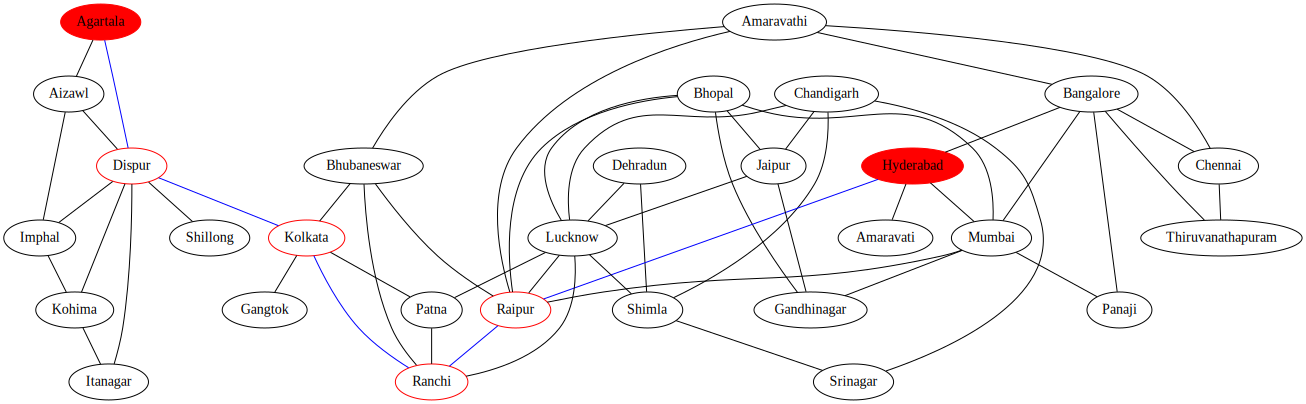

In [28]:
l = Simple_Problem_Solving_Agent(['Agartala', 'Hyderabad'],astar, goal_test)
print('Path Followed', l)

dot = Graph(strict=True)

for x in cities.keys():
    dot.node(x,x)
for x in cities.keys():
    for y in cities[x]:
        dot.edge(x,y[0])

dot.node(l[0], l[0], color = 'red', style = 'filled')
dot.node(l[len(l)-1], l[len(l)-1], color = 'red', style = 'filled')
for i in range(1, len(l)-1):
    dot.node(l[i], l[i], color = "red")
for i in range(0, len(l)-1):
    dot.edge(l[i], l[i+1], color = "blue")
print()
dot

### Input Output
Takes in the user input, calls the problem solving agent and prints the sequence.

Enter Source: Agartala
Enter Destination: Patna
Enter  method bfs, dfs, bi_bfs, astar: astar
Path cost:  2154.0
Path Followed ['Agartala', 'Dispur', 'Kolkata', 'Patna']



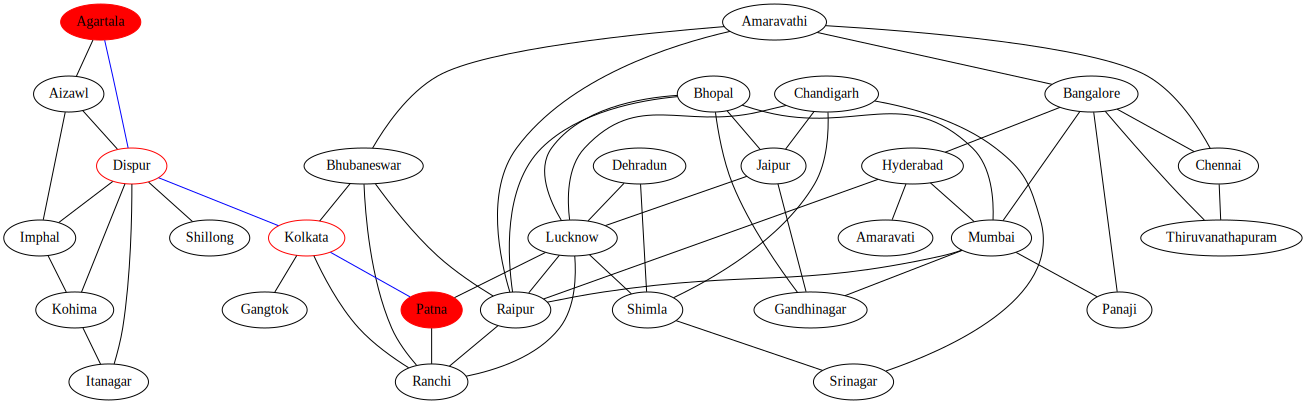

In [31]:
source = input('Enter Source: ')
destination = input('Enter Destination: ')
method = input('Enter  method bfs, dfs, bi_bfs, astar: ')
mapper = {'bfs':bfs, 'dfs':dfs, 'bi_bfs':bi_directional_bfs, 'astar':astar}

l = Simple_Problem_Solving_Agent([source, destination],mapper[method], goal_test)
print('Path Followed', l)

dot = Graph(strict=True)

for x in cities.keys():
    dot.node(x,x)
for x in cities.keys():
    for y in cities[x]:
        dot.edge(x,y[0])


dot.node(l[0], l[0], color = 'red', style = 'filled')
dot.node(l[len(l)-1], l[len(l)-1], color = 'red', style = 'filled')
for i in range(1, len(l)-1):
    dot.node(l[i], l[i], color = "red")
for i in range(0, len(l)-1):
    dot.edge(l[i], l[i+1], color = "blue")
print()
dot